<a href="https://colab.research.google.com/github/iypc-team/CoLab/blob/master/Sonnet_2_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
assert sys.version_info >= (3, 6), "Sonnet 2 requires Python >=3.6"

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
from IPython.display import clear_output
!pip install dm-sonnet==2.0.0b0 gast==0.2.2 tqdm
clear_output()
print("Installs completed.")

Installs completed.


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

In [0]:
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds

In [6]:
print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))

TensorFlow version: 2.0.0
    Sonnet version: 2.0.0b0


In [7]:
print("Available GPUs:")
!grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'

Available GPUs:
 Tesla K80


In [8]:
#  Prepare the MNIST dataset
tf.executing_eagerly()
print("Eager execution:", tf.executing_eagerly())
batch_size = 100

def process_batch(images, labels):
  images = tf.squeeze(images, axis=[-1])
  images = tf.cast(images, dtype=tf.float32)
  images = ((images / 255.) - .5) * 2.
  return images, labels
def mnist(split):
  dataset = tfds.load("mnist", split=split, as_supervised=True)
  dataset = dataset.map(process_batch)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  dataset = dataset.cache()
  return dataset

mnist_train = mnist("train").shuffle(10)
mnist_test = mnist("test")
clear_output()
print("MNIST dataset imported and prepared")

MNIST dataset imported and prepared


MNIST contains `28x28` greyscale handwritten digits. Let's take a look at one:

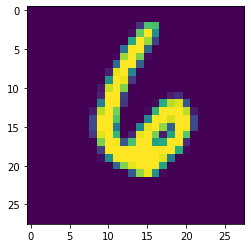

In [9]:
import matplotlib.pyplot as plt

images, _ = next(iter(mnist_test))
plt.imshow(images[0]);

# Sonnet

The next step is to define a model. In Sonnet everything that contains TensorFlow variables (`tf.Variable`) extends `snt.Module`, this includes low level neural network components (e.g. `snt.Linear`,  `snt.Conv2D`), larger nets containing subcomponents (e.g. `snt.nets.MLP`), optimizers (e.g. `snt.optimizers.Adam`) and whatever else you can think of.

Modules provide a simple abstraction for storing parameters (and `Variable`s used for other purposes, like for storing moving avergages in `BatchNorm`).

To find all the parameters for a given module, simply do: `module.variables`. This will return a `tuple` of all the parameters that exist for this module, or any module it references:

## Building the model

In Sonnet you build neural networks out of `snt.Module`s. In this case we'll build a multi-layer perceptron as a new class with a `__call__` method that computes the logits by passing the input through a number of fully connected layers, with a ReLU non-linearity.

In [0]:
class MLP(snt.Module):

  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = snt.Flatten()
    self.hidden1 = snt.Linear(1024, name="hidden1")
    self.hidden2 = snt.Linear(1024, name="hidden2")
    self.logits = snt.Linear(10, name="logits")

  def __call__(self, images):
    output = self.flatten(images)
    output = tf.nn.relu(self.hidden1(output))
    output = tf.nn.relu(self.hidden2(output))
    output = self.logits(output)
    return output

Now we'll create an instance of our class whose weights will be randomly initialized. We'll train this MLP such that it learns to recognize digits in the MNIST dataset.

In [11]:
mlp = MLP()
mlp

MLP()

## Using the model

Let's feed an example input through the model and see what it predicts. Since the model is randomly initialized there is a 1/10 chance that it will predict the right class!

Predicted class: 4 actual class: 6


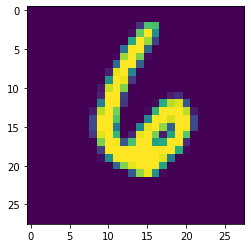

In [12]:
images, labels = next(iter(mnist_test))
logits = mlp(images)
  
prediction = tf.argmax(logits[0]).numpy()
actual = labels[0].numpy()
print("Predicted class: {} actual class: {}".format(prediction, actual))
plt.imshow(images[0]);

## Training the model

To train the model we need an optimizer. For this simple example we'll use Stochastic Gradient Descent which is implemented in the `SGD` optimizer. To compute gradients we'll use a `tf.GradientTape` which allows us to selectively record gradients only for the computation we want to back propagate through:

In [0]:
#@title Utility function to show progress bar.
from tqdm import tqdm

# MNIST training set has 60k images.
num_images = 60000

def progress_bar(generator):
  return tqdm(
      generator,
      unit='images',
      unit_scale=batch_size,
      total=(num_images // batch_size) * num_epochs)


In [14]:
opt = snt.optimizers.SGD(learning_rate=0.1)

num_epochs = 10

def step(images, labels):
  """Performs one optimizer step on a single mini-batch."""
  with tf.GradientTape() as tape:
    logits = mlp(images)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                          labels=labels)
    loss = tf.reduce_mean(loss)

  params = mlp.trainable_variables
  grads = tape.gradient(loss, params)
  opt.apply(grads, params)
  return loss

for images, labels in progress_bar(mnist_train.repeat(num_epochs)):
  loss = step(images, labels)

print("\n\nFinal loss: {}".format(loss.numpy()))

100%|██████████| 600000/600000 [01:04<00:00, 9265.71images/s] 



Final loss: 0.012996380217373371


In [15]:
#  Evaluate the model
total = 0
correct = 0
for images, labels in mnist_test:
  predictions = tf.argmax(mlp(images), axis=1)
  correct += tf.math.count_nonzero(tf.equal(predictions, labels))
  total += images.shape[0]

print("Got %d/%d (%.02f%%) correct" % (correct, total, correct / total * 100.))

Got 9801/10000 (98.01%) correct


To understand the result a bit better, lets take a look at a small sample of where the model correctly identified the digits:

In [0]:
#  Utility function to show a sample of images.
def sample(correct, rows, cols):
  n = 0

  f, ax = plt.subplots(rows, cols)
  if rows > 1:    
    ax = tf.nest.flatten([tuple(ax[i]) for i in range(rows)])
  f.set_figwidth(14)
  f.set_figheight(4 * rows)


  for images, labels in mnist_test:
    predictions = tf.argmax(mlp(images), axis=1)
    eq = tf.equal(predictions, labels)
    for i, x in enumerate(eq):
      if x.numpy() == correct:
        label = labels[i]
        prediction = predictions[i]
        image = images[i]

        ax[n].imshow(image)
        ax[n].set_title("Prediction:{}\nActual:{}".format(prediction, label))

        n += 1
        if n == (rows * cols):
          break

    if n == (rows * cols):
      break

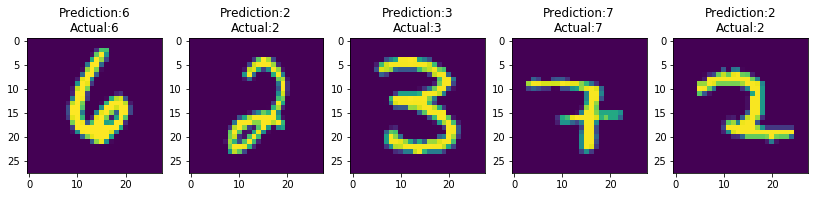

In [17]:
sample(correct=True, rows=1, cols=5)

Now lets take a look at where it incorrectly classifies the input. MNIST has some rather dubious handwriting, I'm sure you'll agree that some of the samples below are a little ambiguous:

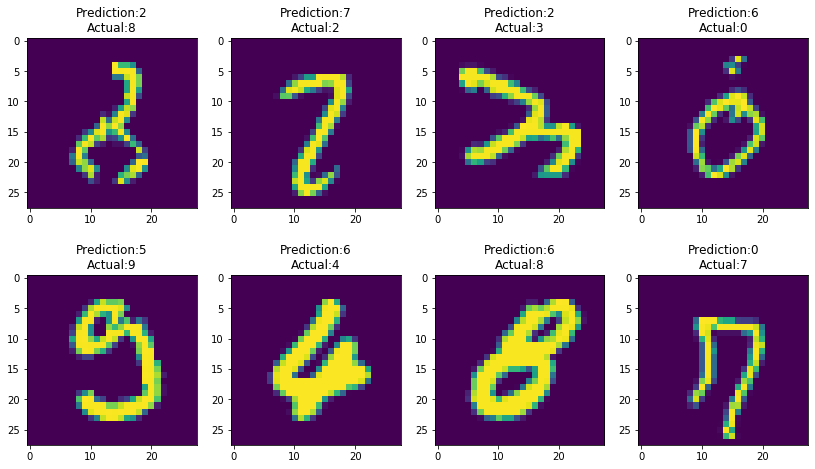

In [18]:

sample(correct=False, rows=2, cols=4)